Графики построены в пакете [Gnuplot.jl](https://github.com/gcalderone/Gnuplot.jl). Интегралы решаются [мотодом Ромберга](https://en.wikipedia.org/wiki/Romberg%27s_method).

For plots use [Gnuplot.jl](https://github.com/gcalderone/Gnuplot.jl) package. Integrals are solved by the [Romberg method](https://en.wikipedia.org/wiki/Romberg%27s_method).

In [ ]:
using Gnuplot

In [ ]:
function trapez(f, bot, top, h)
    
    result = 0.5*(f(bot) + f(top))
    
    for x in (bot+h):h:(top-h)
        result += f(x)
    end
    result * h
end

function romberg(fn, a, b, steps=5, debug=false)

    table = zeros(steps, steps)
    pow_4 = 4 .^ [0:steps-1;] .- 1
    # trapezoidal rule
    h = (b - a)
    table[1] = h * (fn(a) + fn(b)) / 2
    
    for j in 2:steps
        h *= 0.5
        # extended trapezoidal rule
        table[j, 1] = 0.5table[j - 1, 1]
        table[j, 1] += h * sum( i-> fn(a + i*h), 1:2:2^(j-1) )

        # richardson extrapolation
        for k in 2:j
            table[j, k] = table[j, k - 1] +
                (table[j, k - 1] - table[j - 1, k - 1]) / pow_4[k]
        end
    end
    return table[end]
end

In [ ]:
# решает два интеграла одновременно
# solves two integrals simultaneously
function romberg2(fn, a, b, steps=5, debug=false)
    table = fill([0.0, 0.0], steps, steps)
    pow_4 = 4 .^ [0:steps-1;] .- 1
    h = (b - a)
    table[1] .= 0.5h * (fn(a) + fn(b))
    
    for j in 2:steps
        h *= 0.5
        table[j, 1] .= 0.5table[j-1, 1]
        table[j, 1] += h * sum( i-> fn(a + i*h), 1:2:2^(j-1) )
        for k in 2:j
            table[j, k] .= table[j, k - 1] +
                (table[j, k-1] - table[j-1, k-1]) / pow_4[k]
        end
    end
    return table[end]
end

In [ ]:
const ħ = 6.582e-16 # эВ·c
const kT = 0.025
const ieV = 1e-12/ħ 

In [ ]:
function Xres(t, γ = 0.001, Ωᵣ = 0.05)
    if Ωᵣ^2 < 0.25*γ^2
        Om = sqrt( 0.25*γ^2 - Ωᵣ^2 )
        X = exp( -0.5γ*t )*(cosh(Om*t) + 0.5γ/Om*sinh(Om*t) )
    else
        Om = sqrt( Ωᵣ^2 - 0.25*γ^2 )
        X = exp( -0.5γ*t )*( cos(Om*t) + 0.5γ/Om*sin(Om*t) )
    end
    return X
end

Реализация формул (14) и (15):  
Implementation of equations (14) and (15):

In [ ]:
function calcdyn(;ω::Float64, ΔG = -2.5, Eᵣ = 0.2, τₑ = 0.1, ωₑ = 3.0,
                Tm::Array{Float64,1}, γ = 5e-3, Ωᵣ = 1e-2, tq = 1.0, td = 2.0,
                weights::Array{Float64,1} = [0.3, 0.3, 0.4] )
    
    b = Eᵣ*kT
    τₑ *= ieV; td *= ieV; tq *= ieV; T = Tm*ieV
    Zₑ = τₑ*sqrt( 2π^2*b/(2b+τₑ^-2) ) * exp( -(ωₑ + ΔG - Eᵣ)^2 / (4b + 2/(τₑ^2)) )
        
    X(t) = weights[1]*exp( -(t/tq)^2 ) + 
            weights[2]*exp( -t/td ) + 
            weights[3]*Xres(t,γ,Ωᵣ)
    
    function Φ(ξ::Float64, y₁::Float64, t::Float64)
        Xt = X(t-ξ)
        Xt > 1.0 && (Xt = 1.0)
        ħω = y₁ - 2Eᵣ*Xt
        ħδωₑ = ωₑ + ΔG - Eᵣ - ħω*Xt
        σₑ² = 2b*(1 - Xt^2) + τₑ^-2
        (Zₑ*sqrt(σₑ²))^-1 * exp( -ħω^2 / 4b - 2*(ξ/τₑ)^2 - ħδωₑ^2 / 2σₑ² )
    end
    
    y₁ = ω + ΔG + Eᵣ
    #[ ω^3 * trapez( ξ-> Φ(ξ, y₁, t), -5τₑ, t, 1e-2ieV ) for t in T ]
    [  ω^3 * romberg( ξ-> Φ(ξ, y₁, t), -5τₑ, t, 14 ) for t in T ] #
end

In [ ]:
Ωmin = 1.5
Ωmax = 3.2
Tspan = collect(range(0, 3, 256))
Ωspan = collect( range(Ωmin, stop = Ωmax, length = 256) );

In [ ]:
S0 = zeros(length(Ωspan), length(Tspan));

In [ ]:
@time for i in 1:length(Ωspan)
    S0[i, :] .= calcdyn( ω = Ωspan[i], Tm = Tspan, ΔG = -2.5, Eᵣ = 0.2, τₑ = 0.1, ωₑ = 3.0,
                γ = 2e-3, Ωᵣ = 1e-2, weights = [0.3, 0.3, 0.4] ) 
end
for k in 1:length(Tspan)
    S0[:,k] /= maximum(S0[:,k])
end
M1 = [ sum(S0[:,i] .* Ωspan)/sum(S0[:,i]) for i in 1:length(Tspan) ];

In [ ]:
@gp "set title 'Spectra dynamics'" xlab="t, ps" ylab="freq, eV"
@gp :- Tspan Ωspan S0' "w image notit"
@gp :- Tspan M1 "with  lines notit dt 1 lw 2 lc rgb 'green'"

Реализация формул (22) и (23):  
Implementation of equations (22) and (23):

In [ ]:
function calcul(; ΔG = -2.5, Eᵣ = 0.2, τₑ = 0.1, ħωₑ = 3.0,
                Tm::Array{Float64,1}, γ = 5e-3, Ωᵣ = 1e-2, tq = 1.0, td = 2.0,
                weights::Array{Float64,1} = [0.3, 0.3, 0.4] )
    
    E = ΔG + Eᵣ
    U = ΔG - Eᵣ + ħωₑ
    τₑ *= ieV; td *= ieV; tq *= ieV; T = Tm*ieV 
    e = 4Eᵣ*kT
    s = e + 2/τₑ^2
    a = 2e/s
    W = 4Eᵣ + U*a
    Om = sqrt( complex(Ωᵣ^2 - 0.25γ^2) )
    X(t) = weights[1]*exp(-(t/tq)^2) + weights[2]*exp(-t/td) + weights[3]*Xres(t, γ, Ωᵣ)

    function Φ(τ::Float64, t::Float64)
        Q = X(t-τ)#
        Q > 1.0 && (Q = 1.0)
        G = e*(2 - a*Q^2)
        D = 2E - W*Q
        expt2 = exp( -2*τ^2 / τₑ^2 )
        F1 = (3*G^2 + 6G*D^2 + D^4) * expt2
        F2 = (3*G + D^2)*D * expt2
        [F1, F2]
    end
    
    function I(t)
        f1, f2 = romberg2( τ-> Φ(τ, t), -15τₑ, t, 14 )
        -0.5*f1/f2
    end
    [ I(t) for t in T ]
end

Реализация формулы (28):  
Implementation of equation (28):

In [ ]:
using SpecialFunctions

In [ ]:
xx = range(-2,2, 128)
yy = erfc.(xx)
zz = tanh.(xx)
@gp xx yy "with lines notit lw 3 lc rgb 'black'"
@gp :- xx zz "with lines notit lw 3 lc rgb 'blue'"

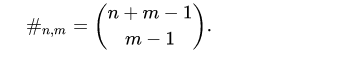

https://en.wikipedia.org/wiki/Multiset#Counting_multisets

https://en.wikipedia.org/wiki/Multinomial_theorem

In [ ]:

function per(n)
    m = 4
    N = binomial(n+m-1, m-1)
    #println(N)
    res = []
    for i in 0:n, j in 0:n-i, k in 0:n-i-j
        push!( res, (i,j,k,n-i-j-k) )
    end
    res
end
pers = per(3)

In [ ]:
function calcfast(; ΔG = -2.5, Eᵣ = 0.2, τₑ = 0.1, ħωₑ = 3.0,
                Tm::Array{Float64,1}, γ = 5e-3, Ωᵣ = 1e-2, tq = 1.0, td = 2.0,
                weights::Array{Float64,1} = [0.3, 0.3, 0.4] )

    E = ΔG + Eᵣ
    U = ΔG - Eᵣ + ħωₑ
    T = Tm*ieV; τₑ *= ieV; td *= ieV; tq *= ieV;
    ε = 4Eᵣ*kT
    ϰ = 2ε*τₑ^2 / (2+ε*τₑ^2)
    W = 4Eᵣ + ϰ*U
    K = 3ϰ*ε - W^2
    L = 2*E^2 + ε
    
    p0 = 4*( L^2 + 2ε*(L+2*E^2) )
    p1 = -16E*W*(L+2ε)
    p2 = -4L*(K-2W^2)
    p3 = 8E*W*K
    p4 = K^2 - 6*ϰ^2*ε^2
    
    q0 = 4E*(L+2ε)
    q1 = -6W*L
    q2 = -2E*(K-2*W^2)
    q3 = K*W
    
    Om = sqrt(complex( Ωᵣ^2 - 0.25*γ^2 ))
    g = 0.5γ/Om
    pers = [ per(n) for n in 1:4 ]
    
    function modesprod(t,k,l,m,n)
        a = 2/τₑ^2 
        c = k/tq^2
        b = 0.5γ*(m+n) + l/td + im*Om*(m-n)
        w = weights[1]^k * weights[2]^l * 
            (0.5weights[3])^(m+n) * (1-im*g)^n * (1+im*g)^m
        ac = a+c
        bc = b+2c*t
        ba = b-2a*t
        ee = exp( 0.25*(b*ba - 2a*t*bc)/ac )
        er = 0.5*ba/sqrt(ac)
        w * ee * erfc(er) / sqrt(ac)
    end
    
    function oneterm(t, i)
        k,l,m,n = i
        koef = factorial(k+l+m+n) / ( factorial(k)*factorial(l)*factorial(m)*factorial(n) )
        koef * modesprod(t,k,l,m,n)
    end
    
    polin(t, n) = sum( i-> oneterm(t, i), pers[n] )
    
    function I2(t)
        pols0 = modesprod(t,0,0,0,0)
        pols1 = polin(t, 1)
        pols2 = polin(t, 2)
        pols3 = polin(t, 3)
        pols4 = polin(t, 4)
        
        F1 = p0*pols0 + p1*pols1 + p2*pols2 + p3*pols3 + p4*pols4  
        F2 = q0*pols0 + q1*pols1 + q2*pols2 + q3*pols3
        -0.5*real(F1/F2)
    end
    
    [ I2(t) for t in T ]
end

In [ ]:
@time M1b = calcul(Tm = Tspan, ΔG = -2.5, Eᵣ = 0.2, τₑ = 0.1, ħωₑ = 3.0,
                γ = 2e-3, Ωᵣ = 1e-2, weights = [0.3, 0.3, 0.4]);

Первый запуск медленнее из-за предкомпиляции  
First run is slower due to precompilation

In [ ]:
@time M1c = calcfast(Tm = Tspan, ΔG = -2.5, Eᵣ = 0.2, τₑ = 0.1, ħωₑ = 3.0,
                γ = 2e-3, Ωᵣ = 1e-2, weights = [0.3, 0.3, 0.4]);

In [ ]:
@gp Tspan M1c "with lines tit 'newnew' lw 4 lc rgb 'black'"
@gp :- Tspan M1b "with  lines tit 'new' dt 3 lw 2 lc rgb 'orange'"
@gp :- Tspan M1 "with  lines tit 'old' dt 3 lw 1 lc rgb 'green'"

In [ ]:
sum(abs, M1c-M1b)

In [ ]:
@gp Tspan M1b-M1c "with lines notit lw 3"

In [ ]:
moms1 = calcfast( Tm = Tspan, ΔG = -2.5, Eᵣ = 0.5 );
moms2 = calcfast( Tm = Tspan, ΔG = -1.5, Eᵣ = 0.5 );
moms3 = calcfast( Tm = Tspan, ΔG = -0.6, Eᵣ = 0.5 );

moms1b = calcfast( Tm = Tspan, ΔG = -2.5, Eᵣ = 0.1 );
moms2b = calcfast( Tm = Tspan, ΔG = -1.5, Eᵣ = 0.1 );
moms3b = calcfast( Tm = Tspan, ΔG = -0.6, Eᵣ = 0.1 );

In [ ]:
fs = 16
  # Helvetica Bold,20
@gp "set xlabel 't, пс' font 'Times New Roman,$fs'"
@gp :- "set ylabel 'ħω, эВ' font 'Times New Roman,$fs'"
@gp :- "set multiplot layout 1,2"
@gp :- 1 "set title 'Er = 0.5 эВ' font 'Times New Roman,$fs'"
@gp :- "set key title 'ΔG'"
@gp :-   Tspan moms1 "with lines tit '-0.6' dt 1 lw 3 lc rgb 'red'"
@gp :-   Tspan moms2 "with lines tit '-1.5' dt 2 lw 3 lc rgb 'green'"
@gp :-   Tspan moms3 "with lines tit '-2.5' dt 3 lw 3 lc rgb 'blue'"
@gp :- 2 "set title 'ΔG = -1.5 эВ' font 'Times New Roman,$fs'"
@gp :- "set key title 'Er'"
@gp :-   Tspan moms1b "with lines tit '1.4' dt 1 lw 3 lc rgb 'red'"
@gp :-   Tspan moms2b "with lines tit '0.5' dt 2 lw 3 lc rgb 'green'"
@gp :-   Tspan moms3b "with lines tit '0.1' dt 3 lw 3 lc rgb 'blue'"

In [ ]:
fs = 16
  # Helvetica Bold,20
@gp "set xlabel 't, пс' font 'Times New Roman,$fs'"
@gp :- "set ylabel 'ħω, эВ' font 'Times New Roman,$fs'"
@gp :- "set key left bottom title 'ΔG, эВ' font 'Times New Roman,$fs'"
@gp :-   Tspan moms1 "with lines tit '-0.6' dt 1 lw 3 lc rgb 'red'"
@gp :-   Tspan moms2 "with lines tit '-1.5' dt 1 lw 3 lc rgb 'black'"
@gp :-   Tspan moms3 "with lines tit '-2.5' dt 1 lw 3 lc rgb 'blue'"
@gp :-   Tspan moms1b "with lines notit dt 4 lw 3 lc rgb 'red'"
@gp :-   Tspan moms2b "with lines notit dt 4 lw 3 lc rgb 'black'"
@gp :-   Tspan moms3b "with lines notit dt 4 lw 3 lc rgb 'blue'"

In [ ]:
Gnuplot.savescript("script_dGs_Ers.gp")

In [ ]:
Gnuplot.save("dGs_Ers.png", term="pngcairo size 600,400 fontscale 1.0")

In [ ]:
moms1 = calcfast( Tm = Tspan, ħωₑ = 3.0, τₑ = 0.4 );
moms2 = calcfast( Tm = Tspan, ħωₑ = 3.0, τₑ = 0.2 );
moms3 = calcfast( Tm = Tspan, ħωₑ = 3.0, τₑ = 0.04 );
moms1b = calcfast( Tm = Tspan, ħωₑ = 3.5, τₑ = 0.1 );
moms3b = calcfast( Tm = Tspan, ħωₑ = 2.5, τₑ = 0.1 );

In [ ]:
fs = 16
  # Helvetica Bold,20
@gp "set xlabel 't, пс' font 'Times New Roman,$fs'"
@gp :- "set ylabel 'ħω, эВ' font 'Times New Roman,$fs'"
@gp :- "set key right top title 'τₑ, пс' font 'Times New Roman,$fs'"
@gp :-   Tspan moms1 "with lines tit '0.4' dt 1 lw 2 lc rgb 'red'"
@gp :-   Tspan moms2 "with lines tit '0.2' dt 1 lw 2 lc rgb 'black'"
@gp :-   Tspan moms3 "with lines tit '0.01' dt 1 lw 2 lc rgb 'blue'"
@gp :-   Tspan moms1b "with lines notit dt 3 lw 3 lc rgb 'black'"
@gp :-   Tspan moms3b "with lines notit dt 2 lw 3 lc rgb 'black'"

In [ ]:
Gnuplot.save("taues.png", term="pngcairo size 600,400 fontscale 1.0")

In [ ]:
moms1 = calcfast( Tm = Tspan, γ = 5e-3, Ωᵣ = 1e-2, td = 4.0, tq = 1.0, weights = [0.3, 0.3, 0.4] );
moms2 = calcfast( Tm = Tspan, γ = 5e-3, Ωᵣ = 1e-2, td = 1.0, tq = 1.0, weights = [0.3, 0.3, 0.4] );
moms3 = calcfast( Tm = Tspan, γ = 5e-3, Ωᵣ = 1e-2, td = 0.5, tq = 1.0, weights = [0.3, 0.3, 0.4] );

moms1b = calcfast( Tm = Tspan, γ = 5e-3, Ωᵣ = 1e-2, td = 4.0, tq = 1.0, weights = [0.5, 0.3, 0.2] );
moms2b = calcfast( Tm = Tspan, γ = 5e-3, Ωᵣ = 1e-2, td = 1.0, tq = 1.0, weights = [0.5, 0.3, 0.2] );
moms3b = calcfast( Tm = Tspan, γ = 5e-3, Ωᵣ = 1e-2, td = 0.5, tq = 1.0, weights = [0.5, 0.3, 0.2] );

In [ ]:
fs = 16
  # Helvetica Bold,20
@gp "set xlabel 't, пс' font 'Times New Roman,$fs'"
@gp :- "set ylabel 'ħω, эВ' font 'Times New Roman,$fs'"
@gp :- "set key right top title 'τ, пс' font 'Times New Roman,$fs'"
@gp :-   Tspan moms1b "with lines notit dt 4 lw 3 lc rgb 'red'"
@gp :-   Tspan moms2b "with lines notit dt 4 lw 3 lc rgb 'black'"
@gp :-   Tspan moms3b "with lines notit dt 4 lw 3 lc rgb 'blue'"
@gp :-   Tspan moms1 "with lines tit '4.0' dt 1 lw 2 lc rgb 'red'"
@gp :-   Tspan moms2 "with lines tit '1.0' dt 1 lw 2 lc rgb 'black'"
@gp :-   Tspan moms3 "with lines tit '0.5' dt 1 lw 2 lc rgb 'blue'"

In [ ]:
Gnuplot.save("weights.png", term="pngcairo size 600,400 fontscale 1.0")